# Visualization of Queensland Road Crash Sites
------------

## Introduction

### Background

Recently I attended (mostly as an observer) the [2019 GovHack event](https://govhack.org/), which describes itself as the "THE LARGEST OPEN DATA HACKATHON IN THE SOUTHERN HEMISPHERE"  (which is a pretty bold claim).  I couldn't commit to the time needed to participate fully (which was why I was mostly observing), but found the process very interesting.  The event was very well run at the [Peregian Digital Hub](https://www.peregianhub.com.au), just north of where I live.  

Govhack provides access to a large array of Government [datasets])(https://hackerspace.govhack.org/data_sets), including [road crash locations for Queensland](https://data.qld.gov.au/dataset/crash-data-from-queensland-roads).

### Goal

The road crash locations databse is one that I have been looking for, as I have a dream of a mobile phone app that would warnimg drivers about dangerous sections of the road, so that they can pay extra care to driving.  This notebook is about the first stage of achieving that dream, in visualizing crash locations in various ways.  I've decided to show the initial data exploration and display, as well as the more polished final results. 

--------------
## Implementation

This sections contains the housekeeping commands related to implementation details.

### Notebook magic commands

Show all graphics inline in notebook.

In [1]:
%matplotlib inline

Watermark is used to show environmental details for reproducability

In [2]:
%load_ext watermark

I use ```black``` as my python code formatter, tailored for Pelican webpage production.

In [3]:
%load_ext lab_black

### Notebook imports

Note that some imports are not actually used by the visualization code, but are there to support display of reproducability information.

In [4]:
# all imports should go here


import sys
import os
import subprocess
import datetime
import platform
import datetime

import seaborn as sns
import pandas as pd
import geopandas as gpd
from cartopy import crs as ccrs
import cartopy.feature as cfeature

from cartopy.io.img_tiles import GoogleTiles

import cartopy.io.img_tiles as cimgt
import six
from PIL import Image

import matplotlib.pyplot as plt

----------------------
## Data Load

### Initial Exploration

So the first thing to do is to load and explore the data (held in a downloaded ```csv``` file.  We get a somewhat opaque warning message: it turns out that the auto-discovery of data column types can get confused by things like PostCodes that (in Australia in any case) mostly look like integers.

In [5]:
crash_path = 'D:\\QLDCrashLocations\\data\\locations.csv'
crashes = pd.read_csv(crash_path)

D:\Anaconda3\envs\ac5-py37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


As usual, we do a ```.head()``` to see what we have.

In [6]:
crashes.head()

,Crash_Ref_Number,Crash_Severity,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Nature,Crash_Type,Crash_Longitude_GDA94,Crash_Latitude_GDA94,...,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_Total,Count_Unit_Car,Count_Unit_Motorcycle_Moped,Count_Unit_Truck,Count_Unit_Bus,Count_Unit_Bicycle,Count_Unit_Pedestrian,Count_Unit_Other
0,1,Property damage only,2001,January,Monday,9,Angle,Multi-Vehicle,152.960485,-26.685052,...,0,0,0,2,0,0,0,0,0,0
1,2,Property damage only,2001,January,Tuesday,23,Hit object,Single Vehicle,153.038263,-27.550776,...,0,0,0,1,0,0,0,0,0,0
2,3,Medical treatment,2001,January,Tuesday,16,Angle,Multi-Vehicle,153.116342,-27.545153,...,1,0,1,2,0,0,0,0,0,0
3,4,Property damage only,2001,January,Tuesday,12,Rear-end,Multi-Vehicle,153.021629,-27.384448,...,0,0,0,2,0,0,0,0,0,0
4,5,Property damage only,2001,January,Tuesday,10,Rear-end,Multi-Vehicle,152.937497,-27.083184,...,0,0,0,3,0,0,0,0,0,0


This all looks promising: lets see what types of crashes we have recorded.

In [7]:
crashes["Crash_Severity"].unique()

array(['Property damage only', 'Medical treatment', 'Hospitalisation',
       'Minor injury', 'Fatal'], dtype=object)

Lets see what the pesky column 15 is all about.

In [8]:
crashes.columns[15]

'Loc_Post_Code'

A little Googling on Stack Overflow reveals the source of the problem.  We declare PostCode to be strings, and reload data (not really necessary, but just checking this fixes the warning message)

In [9]:
crash_path = 'D:\\QLDCrashLocations\\data\\locations.csv'
crashes = pd.read_csv(
    crash_path, dtype={'Loc_Post_Code': str}
)

### Initial Geodata Exploration

At this stage I decide that fatal crashes were the only ones I was interested in, so I create a Pandas view to the ```crashes``` dataframe.  This is a touch unfeeling of me, in that I am using data representing human tragedy and suffering for a blog post to amuse my readers, but my long term goal is an app that might reduce this tragedy.

In [10]:
fatal = crashes[crashes["Crash_Severity"] == 'Fatal']

Let's check what this this gives us.

In [11]:
fatal.head()

,Crash_Ref_Number,Crash_Severity,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Nature,Crash_Type,Crash_Longitude_GDA94,Crash_Latitude_GDA94,...,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_Total,Count_Unit_Car,Count_Unit_Motorcycle_Moped,Count_Unit_Truck,Count_Unit_Bus,Count_Unit_Bicycle,Count_Unit_Pedestrian,Count_Unit_Other
18,19,Fatal,2001,January,Thursday,9,Hit pedestrian,Hit pedestrian,151.934354,-27.566384,...,0,0,1,0,0,1,0,0,1,0
148,149,Fatal,2001,January,Friday,14,Hit object,Single Vehicle,148.702519,-21.623856,...,0,0,1,0,1,0,0,0,0,0
154,155,Fatal,2001,January,Monday,15,Hit object,Single Vehicle,153.018326,-27.275777,...,0,0,1,1,0,0,0,0,0,0
177,178,Fatal,2001,January,Wednesday,2,Hit object,Single Vehicle,153.388039,-27.937847,...,0,0,2,1,0,0,0,0,0,0
285,286,Fatal,2001,February,Friday,17,Head-on,Multi-Vehicle,152.073306,-26.881843,...,0,1,3,2,0,0,0,0,0,0


Let's see how many fatal crashes we have.  Turns out that we have quite a few.

In [12]:
len(fatal)

4761

Now, let's explore the geographic data, and check that it looks reasonable.

In [13]:
fatal["Crash_Longitude_GDA94"].min()

138.11879852299998

In [14]:
fatal["Crash_Longitude_GDA94"].max()

153.54953899999998

The range of Longitude values looks reasonable for Queensland.  If we look at the dataframe for all crashes, we see that there are some crashes with a suspicious (wrong) value.  Clearly, some crashes have a missing Longtitude value, that gets coded as 0.0 in the csv file.

In [15]:
crashes["Crash_Longitude_GDA94"].min()

0.0

Let's see how many crashes have no Lat/Lon values. 

In [16]:
len(crashes[crashes["Crash_Longitude_GDA94"] < 0.1])

598

Compared to the total numbers of crashes, the fraction with Lat/Lon missing values  is quite small.

In [17]:
len(crashes[crashes["Crash_Longitude_GDA94"] > 0.1])

327649

It turns out that all the fatal crashes have a recorded Lat/Lon pair.

In [18]:
len(fatal[fatal["Crash_Longitude_GDA94"] > 0.1])

4761

At this stage, I decided to use GeoPandas, to support my preliminary visualizations.  We show all the columns again, to refresh my memory of what data we have.  I could have chosen to extract just the Lat/Lon pairs, but decided to keep all the data columns in my GeoPandas data structures: the numbers of rows is not huge, and I may choose to use this data somewhere in my visualizations.

In [19]:
fatal.columns

Index(['Crash_Ref_Number', 'Crash_Severity', 'Crash_Year', 'Crash_Month',
       'Crash_Day_Of_Week', 'Crash_Hour', 'Crash_Nature', 'Crash_Type',
       'Crash_Longitude_GDA94', 'Crash_Latitude_GDA94', 'Crash_Street',
       'Crash_Street_Intersecting', 'State_Road_Name', 'Loc_Suburb',
       'Loc_Local_Government_Area', 'Loc_Post_Code', 'Loc_Police_Division',
       'Loc_Police_District', 'Loc_Police_Region',
       'Loc_Queensland_Transport_Region', 'Loc_Main_Roads_Region',
       'Loc_ABS_Statistical_Area_2', 'Loc_ABS_Statistical_Area_3',
       'Loc_ABS_Statistical_Area_4', 'Loc_ABS_Remoteness',
       'Loc_State_Electorate', 'Loc_Federal_Electorate',
       'Crash_Controlling_Authority', 'Crash_Roadway_Feature',
       'Crash_Traffic_Control', 'Crash_Speed_Limit',
       'Crash_Road_Surface_Condition', 'Crash_Atmospheric_Condition',
       'Crash_Lighting_Condition', 'Crash_Road_Horiz_Align',
       'Crash_Road_Vert_Align', 'Crash_DCA_Code', 'Crash_DCA_Description',
       'Crash_

### Creating a GeoPandas DataFrame

In [20]:
fatal_gdf = gpd.GeoDataFrame(
    fatal,
    geometry=gpd.points_from_xy(
        fatal.Crash_Longitude_GDA94,
        fatal.Crash_Latitude_GDA94,
    ),
)

The Lat/Lon pairs in the geometry column look reasonable.

In [21]:
fatal_gdf.geometry.head()

18     POINT (151.934353976 -27.566383584)
148    POINT (148.702518587 -21.623855674)
154    POINT (153.018325532 -27.275777136)
177    POINT (153.388038935 -27.937846918)
285    POINT (152.073305579 -26.881843464)
Name: geometry, dtype: object

We now do the almost the most minimal visualization.  It turns out that the Natural Earth world dataset doesn't think that Australia is a continent, so I had to use Oceania, which includes French Polynesia on the far side of the Date Line.

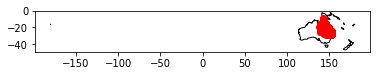

In [22]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

# We restrict to Oceania
ax = world[world.continent == 'Oceania'].plot(
    color='white', edgecolor='black'
)

# We can now plot our ``GeoDataFrame``.
fatal_gdf.plot(ax=ax, color='red')

plt.show()

A listing of what Natural Earth thinks are the continents(?!).

In [23]:
world.continent.unique()

array(['Oceania', 'Africa', 'North America', 'Asia', 'South America',
       'Europe', 'Seven seas (open ocean)', 'Antarctica'], dtype=object)

The absolutely minimal GeoPandas visualization.  You can make out the shape of Queensland, and even what I suspect is Birdsville in the South West corner.

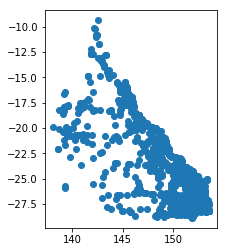

In [24]:
fatal_gdf.plot()

--------------------------
## Mapping fatal crashes

### Supporting functions and definitions 
In this section, I produce some more detailed maps.  In some, I use a basemap showing roads and towns, and I have chosen Google and Stamen as the source for these backgrounds.

Define an imagery class for Stamen, should we decide to use it.

In [25]:
class StamenTerrain(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://tile.stamen.com/terrain/{}/{}/{}.png'.format(
            z, x, y
        )
        return url

    # end _image_url


# end StamenTerrain

We have to chose a Coordinate Reference System (CRS) for our maps.  To make things easy, I have chosen PlateCarree: Queensland looks OK in this projection (unlike, say continential USA).  We re-create the GeoPandas dataframe.

In [26]:
# define the CRS we will use for all maps

my_crs = ccrs.PlateCarree()

fatal_gdf = gpd.GeoDataFrame(
    fatal,
    geometry=gpd.points_from_xy(
        fatal.Crash_Longitude_GDA94,
        fatal.Crash_Latitude_GDA94,
    ),
)

### Plotting Queensland Fatal Crashes

In this figure, I use the higher resolution coastline and state borders (1:10M) to provide geographic context.  I manually set the extent of the map. 

Each fatal crash is shown as a dot with a very low ```alpha``` (i.e. very translucent), so that areas with high fatal crash density are easier to perceive.  Mount Isa is unexpectedly very prominent.

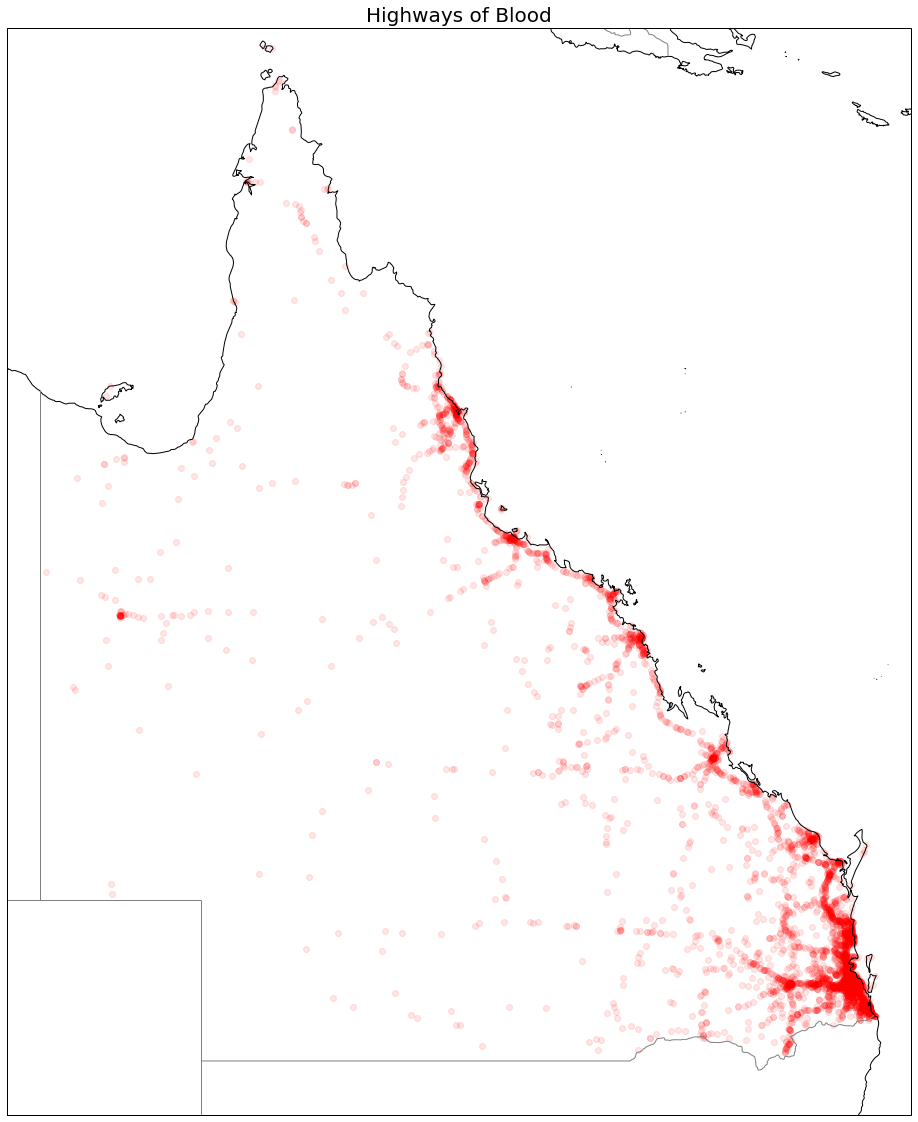

In [33]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(1, 1, 1, projection=my_crs)

ax.set_extent((137.4, 154.2, -30, -9.8), crs=my_crs)
ax.coastlines(resolution='10m')

# Create a feature for States/Admin 1 regions at 1:10m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none',
)

# plot state border
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(states_provinces, edgecolor='gray')

# plot fatal crashes
fatal_gdf.plot(ax=ax, color='red', alpha=0.1)

# set title
ax.set_title('Highways of Blood', fontsize=20)

plt.show()

### Showing Local Crashes

If we want to show the local area (for, say a Sunday drive), then we need more geographic context, showing roads and towns. The example below shows fatal crashes in the context of Google tiles.  I have chosen to use the CRS of the image tiles for this map, as re-projecting images can result in a fuzzy looking basemap.

As before, the map extent is set manually to my local patch, and the zoom level is set manually to a value that looks good, and has the right amount of detail.  On the recommendation of Stack Overflow, I have the ```interpolation='spline36'``` parameter on the ```add_image``` call, as it might improve image quality if I choose a different CRS.

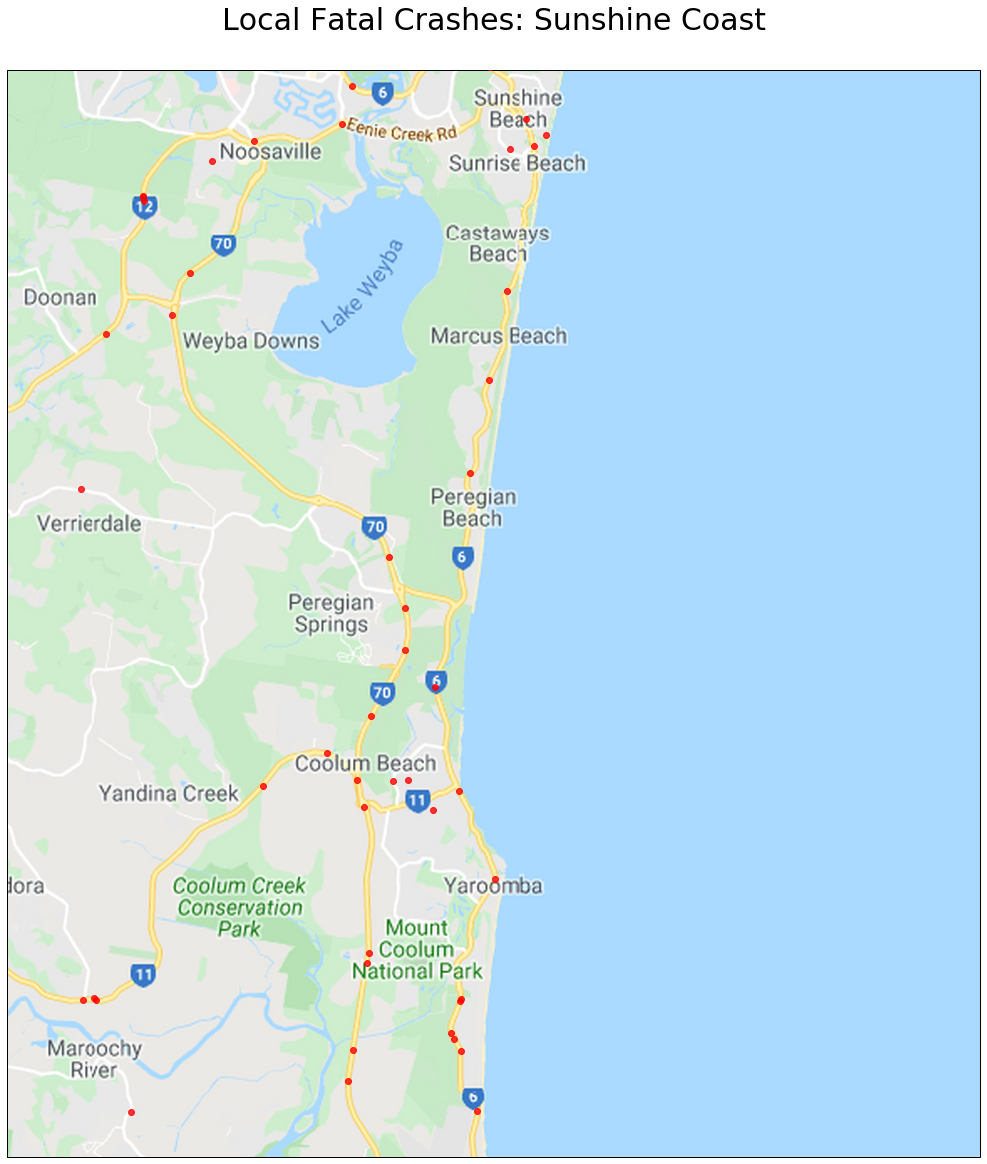

In [28]:
fig = plt.figure(figsize=(20, 20))

imagery = cimgt.GoogleTiles()

ax = plt.axes(projection=imagery.crs)
ax.set_extent(
    (153, 153.2, -26.6, -26.4), crs=ccrs.PlateCarree()
)

# Add the imagery to the map.
zoom = 12

ax.add_image(imagery, zoom, interpolation='spline36')


# Here's what the plot looks like in GeoPandas
crs_proj4 = imagery.crs.proj4_init
fatal_gdf.crs = {'init': 'epsg:4326'}
fatal_gdf2 = fatal_gdf.to_crs(crs_proj4)
fatal_gdf2.plot(ax=ax, color='red', alpha=0.8, zorder=4)

plt.title(
    "Local Fatal Crashes: Sunshine Coast",
    {"fontsize": 30},
    pad=40,
)
plt.show()

The diagram above represents a mock-up of what might be my final app UI.  If you use Google Maps to plan a trip, then the red dots representing fatal crashes might allow the user to avoid 'Black Spots', and show where extra care might be needed.

-------------------------
## Conclusions / Summary

This is a work in progress: the nxet steps will be to try Folium, and get a fata crash webserver going.

-------------------
## Reproducibility

This section of the notebook provides information to support reproducability.

### Notebook version status

In [29]:
theNotebook = (
    '2019-10-21-dc-QLDCrashLocationsNotebook.ipynb'
)

In [30]:
# show info to support reproducibility


def python_env_name():
    envs = subprocess.check_output(
        'conda env list'
    ).splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(
        filter(lambda s: '*' in str(s), envu)
    )[0]
    env_name = str(active_env).split()[0]
    return env_name


# end python_env_name

print('python version : ' + sys.version)
print('python environment :', python_env_name())
print('pandas version : ' + pd.__version__)

print('current wkg dir: ' + os.getcwd())
print('Notebook name: ' + theNotebook)
print(
    'Notebook run at: '
    + str(datetime.datetime.now())
    + ' local time'
)
print(
    'Notebook run at: '
    + str(datetime.datetime.utcnow())
    + ' UTC'
)
print('Notebook run on: ' + platform.platform())

python version : 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
python environment : ac5-py37
pandas version : 0.23.4
current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\QLDCrashLocationsNotebookProject\develop
Notebook name: 2019-10-21-dc-QLDCrashLocationsNotebook.ipynb
Notebook run at: 2019-12-02 15:17:56.451019 local time
Notebook run at: 2019-12-02 05:17:56.451019 UTC
Notebook run on: Windows-10-10.0.18362-SP0


In [31]:
%watermark

2019-12-02T15:17:56+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [32]:
%watermark -h -iv

platform   1.0.8
seaborn    0.9.0
matplotlib 3.0.2
pandas     0.23.4
geopandas  0.5.1
cartopy    0.17.0
PIL.Image  5.3.0
six        1.12.0
host name: DESKTOP-SODFUN6
